## Notebooks for benchmarking the seq2symm method and QUEEN 

In [ ]:
# imports 
import pickle 
import pandas as pd
import re
from ast import literal_eval
from scipy import stats
from collections import Counter

In [ ]:
# read in the oligomeric state of these as deposited in the pdb 
alphafold_known_state = pickle.load(open('../files/../files/phrogs_pass_plddt_length_threshold_oligomeric_state.pkl', 'rb'))

# apply criteria to filter this dictionary 
keys = list(alphafold_known_state.keys())

phrogs_pass_alphafold_seen_state = dict()
labelled_monomers = [] # flag the monomers as these require manual curation 

for k in keys: 
    
    # see if phrog has been curated as a Monomer manually
    # nothing is happening here at the moment - not currently incorporating the manual check 

    if list(alphafold_known_state.get(k).keys()) == ['Monomer']: # this here is if it is only ever listed as a monomer 
        phrogs_pass_alphafold_seen_state[k] = 'Monomer'
        labelled_monomers.append(k)
    
    # otherwise look at pdb hits 
    else: 
        states = alphafold_known_state.get(k)

        # correct any keys in states that mention more than one state
        double_keys = [s for s in list(states.keys()) if '\'' in s] 
        if len(double_keys) > 0: 

            for j in double_keys: 
                split = re.split(', ', j) 
                for s in split: 
                    if s in list(states.keys()):
                        states[s.replace('\'', '')] += 1
                    else: 
                        states[s.replace('\'', '')] = 1

                del states[j]

    
        # Delete monomers from the states dictionary - if there is a high state this is more likely 
        if 'Monomer' in list(states.keys()):
            del states['Monomer']
            
        # TODO return here to see if there are any missing from the manual curation 
        
        # apply criteria that there shouldn't be more than 3 possible states 
        if len(states) > 3: 
            phrogs_pass_alphafold_seen_state[k] = 'ambiguous'
        
        # check that the 'winning' state represents at least 70% of the hits 
        else: 
            
            if len(states) > 0: 
                
                # generate a dataframe with number of hits to each state
                hits_df = pd.DataFrame.from_dict(states, orient='index').sort_values(0, ascending=False)
                
                # compute the 'dominance' of this top state 
                dominance = hits_df.iloc[0]/hits_df[0].sum()
                
                if dominance[0] >= 0.65: 
                    phrogs_pass_alphafold_seen_state[k] = hits_df.index[0]
                else: 
                    phrogs_pass_alphafold_seen_state[k] = 'ambiguous'

                #print(states)

In [ ]:
# read in predictions made with seq2symm 

In [381]:
# Read the CSV file
seq2symm_results = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/monomers/seq2symmpredictions.csv')

# Convert the 'predicted_oligomerization_state' column from string representation to actual dictionary
seq2symm_results['predicted_oligomerization_state'] = seq2symm_results['predicted_oligomerization_state'].apply(literal_eval)

# Unpack the dictionary column into separate columns
oligomerization_columns = seq2symm_results['predicted_oligomerization_state'].apply(pd.Series)

# Join the unpacked columns back into the original dataframe
seq2symm_results = seq2symm_results.join(oligomerization_columns)

# Now, 'seq2symm_results' will have separate columns for each oligomerization state
print(seq2symm_results.head())


def get_best_symmetry(row):
    # Find the column with the highest score (ignoring NaNs)
    best_symmetry = row.dropna().idxmax()  # Get the column name (symmetry)
    best_score = row[best_symmetry]        # Get the corresponding score
    return pd.Series([best_symmetry, best_score], index=['best_symmetry', 'best_score'])

# Apply the function to each row (excluding 'fasta_id' and 'predicted_oligomerization_state')
best_symmetry_df = seq2symm_results.drop(columns=['fasta_id', 'predicted_oligomerization_state']).apply(get_best_symmetry, axis=1)

# Add 'fasta_id' to the new dataframe
best_symmetry_df['fasta_id'] = seq2symm_results['fasta_id']

# Reorder the columns so 'fasta_id' is the first column
best_symmetry_df = best_symmetry_df[['fasta_id', 'best_symmetry', 'best_score']]

# Display the new dataframe
print(best_symmetry_df.head())

best_symmetry_df['curated_state'] = [phrogs_pass_alphafold_seen_state.get(f) for f in best_symmetry_df['fasta_id']]

      fasta_id                    predicted_oligomerization_state      C1  \
0   phrog_1004  {'C1': 0.5384, 'C3': 0.1549, 'D3': 0.1014, 'C2...  0.5384   
1  phrog_10132                       {'C2': 0.8364, 'D2': 0.1422}     NaN   
2   phrog_1017  {'C1': 0.7676, 'C2': 0.1615, 'D3': 0.026, 'C3'...  0.7676   
3    phrog_102  {'C1': 0.6135, 'C2': 0.3076, 'D3': 0.034, 'C3'...  0.6135   
4  phrog_10365  {'C2': 0.4824, 'C1': 0.3358, 'C4': 0.0359, 'D2...  0.3358   

       C3      D3      C2     C6      C5     C17       I      D2      C4  \
0  0.1549  0.1014  0.0575  0.052  0.0273  0.0157  0.0117  0.0109     NaN   
1     NaN     NaN  0.8364    NaN     NaN     NaN     NaN  0.1422     NaN   
2  0.0119  0.0260  0.1615    NaN     NaN     NaN     NaN  0.0109  0.0118   
3  0.0139  0.0340  0.3076    NaN     NaN     NaN     NaN     NaN  0.0115   
4  0.0109  0.0288  0.4824    NaN     NaN     NaN  0.0102  0.0346  0.0359   

       D4  C9   O  D12   H   T  D5  
0     NaN NaN NaN  NaN NaN NaN NaN  
1     

In [382]:
# compare this with my curated states
symmetry_subunits = {'C1': 'Monomer',
 'C17': 'Homo 17-mer',
 'C2': 'Homo 2-mer',
 'C3': 'Homo 3-mer',
 'C4': 'Homo 4-mer',
 'C5': 'Homo 5-mer',
 'C6': 'Homo 6-mer',
 'C9': 'Homo 9-mer',
 'D2': 'Homo 4-mer',
 'D3': 'Homo 6-mer',
 'D4': 'Homo 8-mer',
 'D5': 'Homo 10-mer',
 'H': 'helical',
 'I': 'Homo 60-mer',
 'O': 'Homo 24-mer', 
 'T': 'Homo 12-mer'}  # changes these to higher order 


# subunits bins  
bins_subunits = {'Monomer': 'Monomer', 
                'Homo 2-mer': 'Homo 2-mer', 
                'Homo 3-mer': 'Homo 3-mer',
                'Homo 4-mer': 'Homo 4-mer', 
                'Homo 5-mer': 'Homo 5-6-mer', 
                'Homo 6-mer': 'Homo 5-6-mer', 
                'Homo 7-mer': 'Homo 7+-mer', 
                'Homo 8-mer': 'Homo 7+-mer',
                'Homo 9-mer': 'Homo 7+-mer',
                'Homo 10-mer': 'Homo 7+-mer',
                'Homo 12-mer': 'Homo 7+-mer', 
                'Homo 17-mer': 'Homo 7+-mer', 
                'Homo 60-mer': 'Homo 7+-mer', 
                'Homo 24-mer': 'Homo 7+-mer', 
                'helical': 'ambiguous', 
                'ambiguous': 'ambiguous'} 


In [383]:
# Assuming your dataframe is called best_symmetry_df
# Convert the 'curated_state' to the mapped symmetry states
best_symmetry_df['mapped_symmetry'] = best_symmetry_df['best_symmetry'].map(symmetry_subunits)
best_symmetry_df['mapped_symmetry_bin'] = best_symmetry_df['mapped_symmetry'].map(bins_subunits)
best_symmetry_df['curated_state_bin'] = best_symmetry_df['curated_state'].map(bins_subunits)

# Display the updated dataframe
print(best_symmetry_df.head())

# You can now compare the 'mapped_symmetry' with the 'best_symmetry' to check if the predictions are correct
best_symmetry_df['prediction_score'] = (best_symmetry_df['mapped_symmetry_bin'] == best_symmetry_df['curated_state_bin']).astype(int)
best_symmetry_df['is_correct'] = best_symmetry_df['prediction_score'] == 1

# Display the updated dataframe with predictions
print(best_symmetry_df[['fasta_id', 'best_symmetry', 'mapped_symmetry', 'prediction_score', 'is_correct']].head())


      fasta_id best_symmetry  best_score curated_state mapped_symmetry  \
0   phrog_1004            C1      0.5384    Homo 6-mer         Monomer   
1  phrog_10132            C2      0.8364    Homo 2-mer      Homo 2-mer   
2   phrog_1017            C1      0.7676       Monomer         Monomer   
3    phrog_102            C1      0.6135       Monomer         Monomer   
4  phrog_10365            C2      0.4824    Homo 2-mer      Homo 2-mer   

  mapped_symmetry_bin curated_state_bin  
0             Monomer      Homo 5-6-mer  
1          Homo 2-mer        Homo 2-mer  
2             Monomer           Monomer  
3             Monomer           Monomer  
4          Homo 2-mer        Homo 2-mer  
      fasta_id best_symmetry mapped_symmetry  prediction_score  is_correct
0   phrog_1004            C1         Monomer                 0       False
1  phrog_10132            C2      Homo 2-mer                 1        True
2   phrog_1017            C1         Monomer                 1        True
3  

In [384]:
# make a confusion matrix of the results of the df 

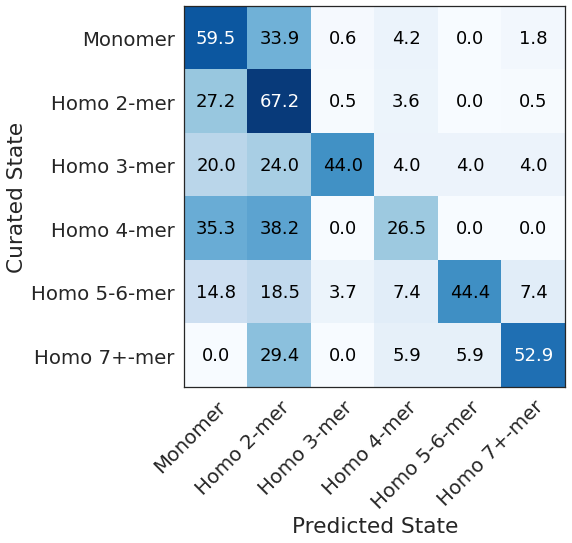

In [385]:
# Filter ambiguous rows (optional)
df = best_symmetry_df[best_symmetry_df['curated_state_bin'] != 'ambiguous'].copy()
sns.set(font_scale=1.8, style='white')

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['mapped_symmetry_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', 'Homo 2-mer', 'Homo 3-mer', 'Homo 4-mer', 'Homo 5-6-mer', 'Homo 7+-mer', 'Helical']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)
# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Set color based on the score (adjust threshold if needed)
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/seq2symm_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# contrast this confusion matrix with confusion of predictions made on the correct predictions 

/home/grig0076/.local/lib/python3.9/site-packages/seaborn/categorical.py:231: RuntimeWarning:

All-NaN slice encountered



OverflowError: Range exceeds valid bounds

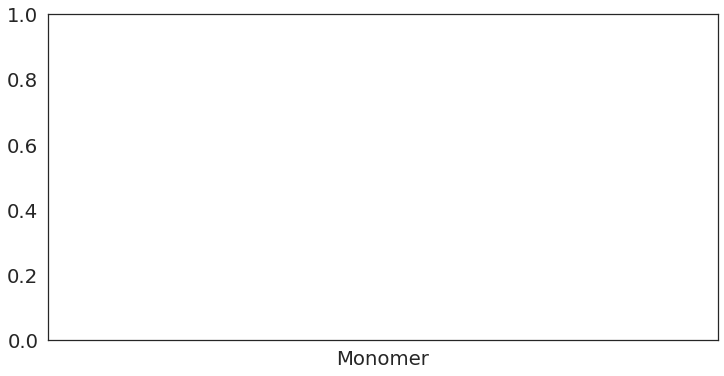

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Drop ambiguous rows
df = best_symmetry_df[best_symmetry_df['curated_state_bin'] != 'ambiguous'].copy()

# Ensure consistent types
df['curated_state_bin'] = df['curated_state_bin'].astype(str)
df['mapped_symmetry_bin'] = df['mapped_symmetry_bin'].astype(str)

# Create column indicating whether prediction was correct
df['is_correct'] = df['curated_state_bin'] == df['mapped_symmetry_bin']

# Optional: short label
df['correct_label'] = df['is_correct'].map({True: "Correct", False: "Incorrect"})

# Plot
desired_order = ['Monomer', 'Homo 2-mer', 'Homo 3-mer', 'Homo 4-mer', 'Homo 5-6-mer', 'Homo 7+-mer'] 
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=df,
    x='mapped_symmetry_bin',
    y='best_score',
    hue='correct_label',
    jitter=0.25,
    dodge=True,
    palette={'Correct': 'green', 'Incorrect': 'red'},
     order=desired_order,
    alpha=0.6
)
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/seq2symm_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()



## repeat for predictions made with QUEEN 

In [386]:
queen_predictions = pd.read_csv('queen_phrog_validation_set_predictions.tsv', sep='\t', index_col=0)

# great a dictionary to make bins 
bins_num_subunits = {1: 'Monomer', 
                2: 'Homo 2-mer', 
                3: 'Homo 3-mer',
                4: 'Homo 4-mer', 
                5: 'Homo 5-6-mer', 
                6: 'Homo 5-6-mer', 
                7: 'Homo 7+-mer', 
                8: 'Homo 7+-mer',
                9: 'Homo 7+-mer',
                10: 'Homo 7+-mer',
                12: 'Homo 7+-mer', 
                24: 'Homo 7+-mer'}
queen_predictions['mapped_subunits_bin'] = [bins_num_subunits.get(s) for s in queen_predictions['num_subunits']]
queen_predictions['curated_state'] = [phrogs_pass_alphafold_seen_state.get(s) for s in queen_predictions['phrog']]
queen_predictions['curated_state_bin'] = [bins_subunits.get(phrogs_pass_alphafold_seen_state.get(s)) for s in queen_predictions['phrog']] 

# You can now compare the 'mapped_symmetry' with the 'best_symmetry' to check if the predictions are correct
queen_predictions['prediction_score'] = (queen_predictions['mapped_subunits_bin'] == queen_predictions['curated_state_bin']).astype(int)
queen_predictions['is_correct'] = queen_predictions['prediction_score'] == 1

# Filter ambiguous rows (optional)
df = queen_predictions[queen_predictions['curated_state_bin'] != 'ambiguous'].copy()

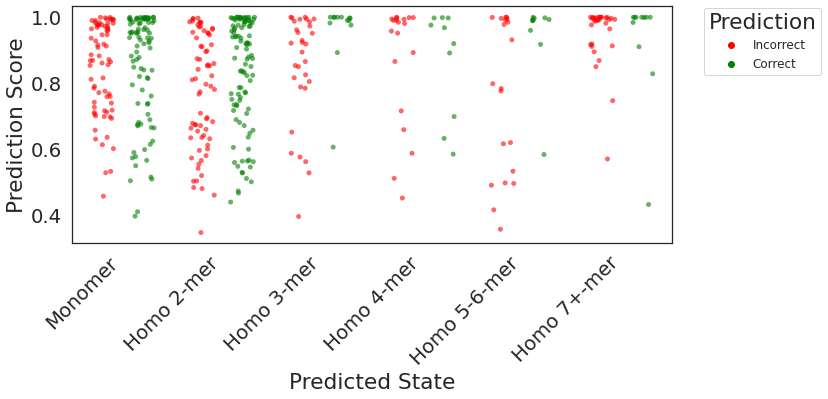

In [387]:
# Optional: short label
df['correct_label'] = df['is_correct'].map({True: "Correct", False: "Incorrect"})

# Plot
desired_order = ['Monomer', 'Homo 2-mer', 'Homo 3-mer', 'Homo 4-mer', 'Homo 5-6-mer', 'Homo 7+-mer'] 
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=df,
    x='mapped_subunits_bin',
    y='probability',
    hue='correct_label',
    jitter=0.25,
    dodge=True,
    palette={'Correct': 'green', 'Incorrect': 'red'},
     order=desired_order,
    alpha=0.6
)
plt.xlabel("Predicted State")
plt.ylabel("Prediction Score")
plt.legend(
    title="Prediction",
    loc='upper left',  # Position inside the plot area (upper left corner)
    bbox_to_anchor=(1.05, 1),  # Move legend outside the plot (right side)
    borderaxespad=0.1,  # Adjust spacing between plot and legend
    fontsize=12
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/queen_scoredistribution.png',  dpi=300, bbox_inches='tight')
plt.show()



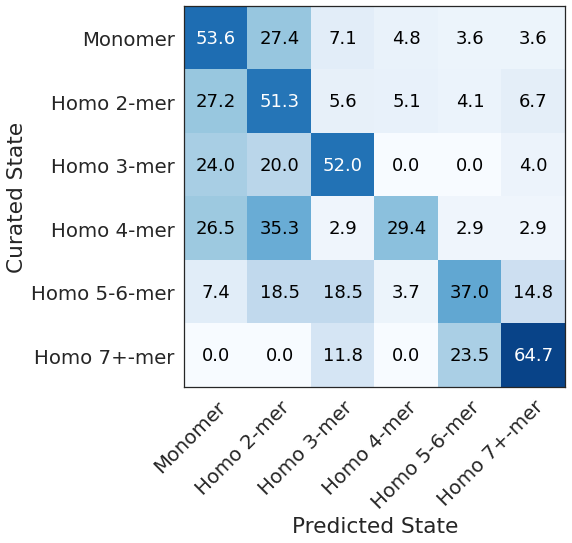

In [366]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter ambiguous rows (optional)
# df = best_symmetry_df[best_symmetry_df['curated_state_bin'] != 'ambiguous'].copy()

# Create normalized confusion matrix
cm = pd.crosstab(
    df['curated_state_bin'],
    df['mapped_subunits_bin'],
    normalize='index'  # Normalize so rows sum to 1
)

# Define custom order with Monomer first
desired_order = ['Monomer', 'Homo 2-mer', 'Homo 3-mer', 'Homo 4-mer', 'Homo 5-6-mer', 'Homo 7+-mer']

# Reorder rows and columns to match desired order
available_rows = [label for label in desired_order if label in cm.index]
available_cols = [label for label in desired_order if label in cm.columns]

cm = cm.reindex(index=available_rows, columns=available_cols, fill_value=0)

# Convert to numpy array and get labels
cm_array = cm.values
row_labels = cm.index.tolist()
col_labels = cm.columns.tolist()

# Create the plot using matplotlib imshow with manual annotations
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_array, cmap='Blues', aspect='auto', vmax=0.7)  # Set vmax to 0.7

# Add colorbar
#cbar = plt.colorbar(im, shrink=0.8)

# Force the plot to be square
ax.set_aspect('equal')


# Set ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations manually with dynamic color based on the value
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        score = cm_array[i, j]
        text_color = "black" if score < 0.5 else "white"  # Adjust threshold as needed
        ax.text(j, i, f'{score*100:.1f}', ha="center", va="center", color=text_color, fontsize=18)

ax.set_xlabel("Predicted State")
ax.set_ylabel("Curated State")
fig.tight_layout()
plt.savefig('../figures/queen_confusionmatrix.png',  dpi=300, bbox_inches='tight')
plt.show()
